Setup Environment dan Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

print("✅ Colab ready + Drive mounted")


Mounted at /content/drive
✅ Colab ready + Drive mounted


Load Dataset dari Drive

In [ ]:
file_path = '/content/drive/MyDrive/complete_data.csv'

df = pd.read_csv(file_path)

print("✅ Dataset loaded from Drive")
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values per kolom:\n", df.isnull().sum())

display(df.head())


✅ Dataset loaded from Drive
Shape: (215371, 11)

Columns: ['province_name', 'city_name', 'district_name', 'school_name', 'stage', 'status', 'lat', 'long', 'province_area', 'total_population', 'total_education_age_population']

Missing values per kolom:
 province_name                        0
city_name                            0
district_name                        0
school_name                          0
stage                                0
status                               0
lat                               1150
long                              1150
province_area                        0
total_population                     0
total_education_age_population       0
dtype: int64


,province_name,city_name,district_name,school_name,stage,status,lat,long,province_area,total_population,total_education_age_population
0,PAPUA,Kab. Tolikara,Kec. Gilungbandu,SMP SATAP KAGI,SMP,N,-3.415995,138.339704,319036,4418581.0,1517814
1,PAPUA,Kab. Tolikara,Kec. Wunin,SD YPPGI WURINERI,SD,S,-3.479000,138.680000,319036,4418581.0,1517814
2,PAPUA,Kab. Tolikara,Kec. Bokondini,SMAN BOKONDINI,SMA,N,-3.531731,138.658234,319036,4418581.0,1517814
3,PAPUA,Kab. Tolikara,Kec. Kuari,SD INPRES KUARI,SD,N,-3.518100,138.529500,319036,4418581.0,1517814
4,PAPUA,Kab. Tolikara,Kec. Karubaga,SMAS YPPGI KARUBAGA,SMA,S,-3.449100,138.598800,319036,4418581.0,1517814


  Data Preparation

In [ ]:
# 1. Cleaning
def clean_data(df):
    df_clean = df.copy()

    # Isi missing koordinat pake rata-rata provinsi
    if 'lat' in df_clean.columns and 'long' in df_clean.columns:
        df_clean['lat'] = df_clean.groupby('province_name')['lat'].transform(
            lambda x: x.fillna(x.mean()))
        df_clean['long'] = df_clean.groupby('province_name')['long'].transform(
            lambda x: x.fillna(x.mean()))

    # Isi kategori kosong jadi 'Unknown'
    for col in ['stage', 'status', 'province_name', 'city_name']:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna('Unknown')

    return df_clean

df_clean = clean_data(df)

# 2. Feature Engineering
def feature_engineering(df_in):
    df_fe = df_in.copy()

    # Kepadatan penduduk per luas wilayah provinsi
    df_fe['population_density'] = (
        df_fe['total_population'] / df_fe['province_area']
    )

    # Kepadatan penduduk usia sekolah per luas wilayah
    df_fe['education_density'] = (
        df_fe['total_education_age_population'] / df_fe['province_area']
    )

    # Rasio usia sekolah terhadap total penduduk
    df_fe['education_ratio'] = (
        df_fe['total_education_age_population'] / df_fe['total_population']
    )

    # Encode jenjang sekolah
    level_mapping = {'SD': 1, 'SMP': 2, 'SMA': 3, 'SMK': 3, 'SLB': 4}
    df_fe['school_level'] = df_fe['stage'].map(level_mapping)

    # Encode status sekolah
    df_fe['is_public'] = (df_fe['status'].astype(str).str.upper().str.startswith('N')).astype(int)

    return df_fe

df_fe = feature_engineering(df_clean)

# 3. Label encode provinsi ke angka
le_province = LabelEncoder()
df_fe['province_encoded'] = le_province.fit_transform(df_fe['province_name'])

print("✅ Cleaning + Feature Engineering done")
display(df_fe.head())


✅ Cleaning + Feature Engineering done


,province_name,city_name,district_name,school_name,stage,status,lat,long,province_area,total_population,total_education_age_population,population_density,education_density,education_ratio,school_level,is_public,province_encoded
0,PAPUA,Kab. Tolikara,Kec. Gilungbandu,SMP SATAP KAGI,SMP,N,-3.415995,138.339704,319036,4418581.0,1517814,13.849788,4.757501,0.343507,2.0,1,23
1,PAPUA,Kab. Tolikara,Kec. Wunin,SD YPPGI WURINERI,SD,S,-3.479000,138.680000,319036,4418581.0,1517814,13.849788,4.757501,0.343507,1.0,0,23
2,PAPUA,Kab. Tolikara,Kec. Bokondini,SMAN BOKONDINI,SMA,N,-3.531731,138.658234,319036,4418581.0,1517814,13.849788,4.757501,0.343507,3.0,1,23
3,PAPUA,Kab. Tolikara,Kec. Kuari,SD INPRES KUARI,SD,N,-3.518100,138.529500,319036,4418581.0,1517814,13.849788,4.757501,0.343507,1.0,1,23
4,PAPUA,Kab. Tolikara,Kec. Karubaga,SMAS YPPGI KARUBAGA,SMA,S,-3.449100,138.598800,319036,4418581.0,1517814,13.849788,4.757501,0.343507,3.0,0,23


Data Transformation untuk Model

In [ ]:
# Kolom fitur untuk clustering wilayah
cluster_features = [
    'population_density',
    'education_density',
    'education_ratio',
    'school_level',
    'is_public',
    'province_encoded'
]

X_cluster = df_fe[cluster_features].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

print("✅ Data siap untuk clustering (KMeans)")
print("X_cluster shape:", X_cluster.shape)


✅ Data siap untuk clustering (KMeans)
X_cluster shape: (214896, 6)


Clustering (KMeans)

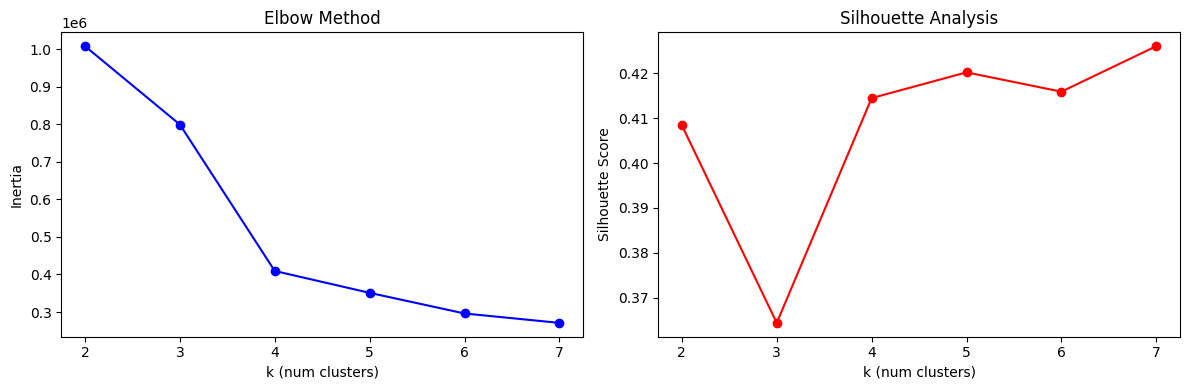

✅ Clustering selesai, dipakai k = 4


,province_name,city_name,stage,status,cluster
0,PAPUA,Kab. Tolikara,SMP,N,1.0
1,PAPUA,Kab. Tolikara,SD,S,0.0
2,PAPUA,Kab. Tolikara,SMA,N,1.0
3,PAPUA,Kab. Tolikara,SD,N,1.0
4,PAPUA,Kab. Tolikara,SMA,S,0.0
5,PAPUA,Kab. Tolikara,SD,N,1.0
6,PAPUA,Kab. Tolikara,SD,N,1.0
7,PAPUA,Kab. Lanny Jaya,SD,N,1.0
8,PAPUA,Kab. Lanny Jaya,SMP,S,0.0
9,PAPUA,Kab. Lanny Jaya,SD,N,1.0


In [ ]:
inertia = []
sil_scores = []

k_range = range(2, 8)
for k in k_range:
    km_tmp = KMeans(n_clusters=k, random_state=42)
    labels_tmp = km_tmp.fit_predict(X_scaled)
    inertia.append(km_tmp.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels_tmp))

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('k (num clusters)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(k_range, sil_scores, 'ro-')
plt.xlabel('k (num clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()

# pilih jumlah cluster
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# simpan label cluster balik ke df_fe
df_fe['cluster'] = pd.Series([np.nan]*len(df_fe), dtype="float")
df_fe.loc[X_cluster.index, 'cluster'] = cluster_labels

print("✅ Clustering selesai, dipakai k =", optimal_k)
df_fe[['province_name','city_name','stage','status','cluster']].head(10)


Classification (Random Forest)

In [ ]:
class_features = [
    'population_density',
    'education_density',
    'education_ratio',
    'school_level',
    'province_encoded',
    'lat',
    'long'
]

# Buat X dan y untuk klasifikasi
X_class = df_fe[class_features].dropna()
y_class = df_fe.loc[X_class.index, 'is_public']

# Split dataset train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_class,
    y_class,
    test_size=0.3,
    random_state=42,
    stratify=y_class
)

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

print("✅ Model RandomForest selesai dilatih")


✅ Model RandomForest selesai dilatih


Evaluation

=== CLUSTERING EVALUATION ===
Silhouette Score: 0.414

Cluster Characteristics:


,population_density,education_density,education_ratio,is_public
cluster,,,,
0.0,722.539,223.021,0.320,0.007
1.0,146.717,50.712,0.349,0.939
2.0,837.765,254.813,0.311,1.000
3.0,16084.264,4872.602,0.303,0.469



=== CLASSIFICATION EVALUATION ===
              precision    recall  f1-score   support

           0       0.65      0.58      0.61     14589
           1       0.88      0.91      0.89     49880

    accuracy                           0.83     64469
   macro avg       0.76      0.74      0.75     64469
weighted avg       0.83      0.83      0.83     64469



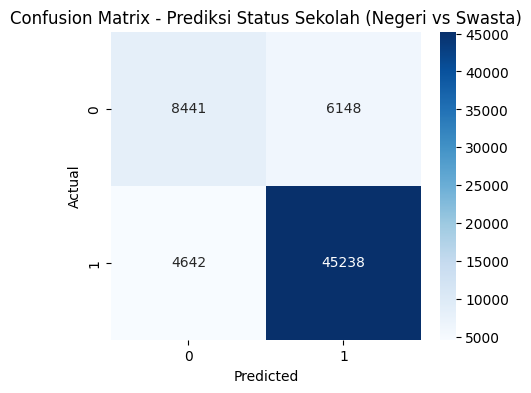

Feature Importance:


,feature,importance
6,long,0.355755
5,lat,0.351252
3,school_level,0.231941
0,population_density,0.022689
1,education_density,0.018161
2,education_ratio,0.011980
4,province_encoded,0.008223


✅ Evaluation done


In [ ]:
# Evaluasi clustering
print("=== CLUSTERING EVALUATION ===")
sil = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {sil:.3f}")

cluster_summary = df_fe.groupby('cluster')[[
    'population_density',
    'education_density',
    'education_ratio',
    'is_public'
]].mean().round(3)
print("\nCluster Characteristics:")
display(cluster_summary)

# Evaluasi classification
print("\n=== CLASSIFICATION EVALUATION ===")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Prediksi Status Sekolah (Negeri vs Swasta)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance dari Random Forest
feature_importance = pd.DataFrame({
    'feature': class_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
display(feature_importance)

print("✅ Evaluation done")


Visualisasi Cluster

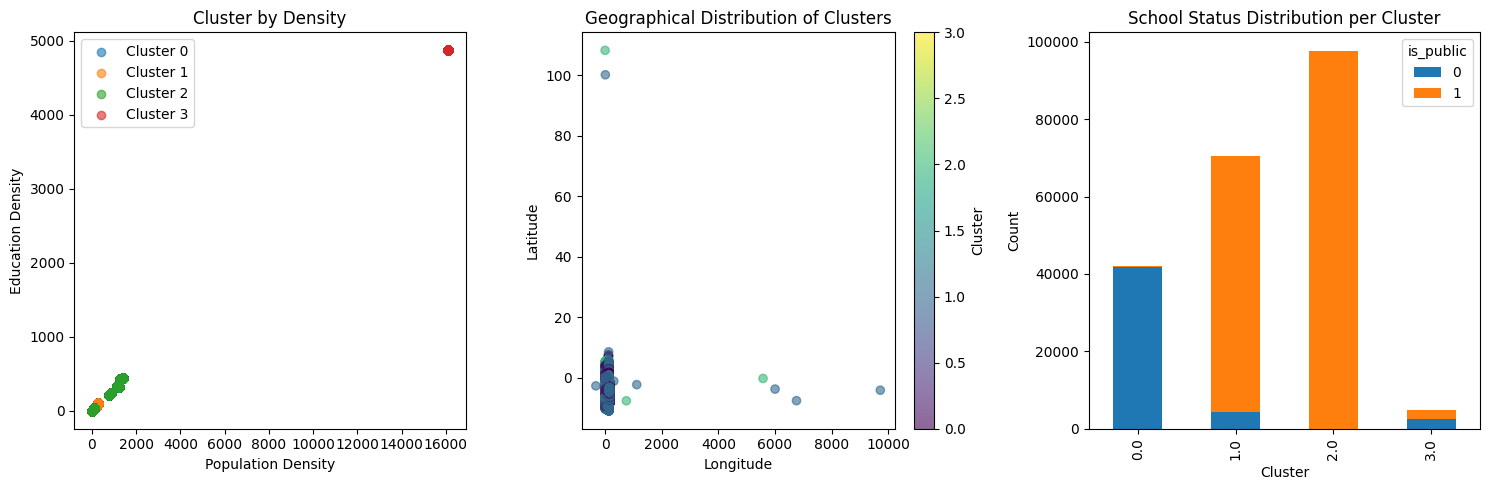

✅ Visualisasi cluster OK


In [ ]:
plt.figure(figsize=(15,5))

# Plot 1: cluster berdasarkan density pendidikan
plt.subplot(1,3,1)
for c in sorted(df_fe['cluster'].dropna().unique()):
    subset = df_fe[df_fe['cluster'] == c]
    plt.scatter(
        subset['population_density'],
        subset['education_density'],
        alpha=0.6,
        label=f'Cluster {int(c)}'
    )
plt.xlabel('Population Density')
plt.ylabel('Education Density')
plt.title('Cluster by Density')
plt.legend()

# Plot 2: peta kasar longitude / latitude
plt.subplot(1,3,2)
scatter = plt.scatter(
    df_fe['long'],
    df_fe['lat'],
    c=df_fe['cluster'],
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of Clusters')

# Plot 3: komposisi negeri vs swasta per cluster
plt.subplot(1,3,3)
cluster_status = pd.crosstab(df_fe['cluster'], df_fe['is_public'])
cluster_status.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('School Status Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("✅ Visualisasi cluster OK")


Deployment dan Report

In [ ]:
joblib.dump(kmeans, '/content/drive/MyDrive/education_cluster_model.pkl')
joblib.dump(rf_classifier, '/content/drive/MyDrive/school_status_predictor.pkl')
joblib.dump(scaler, '/content/drive/MyDrive/feature_scaler.pkl')
joblib.dump(le_province, '/content/drive/MyDrive/province_encoder.pkl')

# Buat ringkasan insight per cluster
def generate_insights_report(df):
    insights = []
    insights.append("=== EDUCATION DISPARITY INSIGHTS ===")
    clusters = sorted(df['cluster'].dropna().unique())

    insights.append(f"Total clusters identified: {len(clusters)}")

    for c in clusters:
        cl_data = df[df['cluster'] == c]

        # province tipikal
        if cl_data['province_name'].dropna().empty:
            typical_prov = "Unknown"
        else:
            typical_prov = cl_data['province_name'].mode()[0]

        insights.append(f"\n--- Cluster {int(c)} ---")
        insights.append(f"Typical Province        : {typical_prov}")
        insights.append(f"Avg Population Density  : {cl_data['population_density'].mean():.2f}")
        insights.append(f"Public School Ratio (0-1): {cl_data['is_public'].mean():.2f}")
        insights.append(f"Number of Schools       : {len(cl_data)}")

    return "\n".join(insights)

report_text = generate_insights_report(df_fe)
print(report_text)

# Simpan data hasil analisis dan laporan
df_fe.to_csv('/content/drive/MyDrive/analyzed_school_data.csv', index=False)

with open('/content/drive/MyDrive/education_analysis_report.txt', 'w') as f:
    f.write(report_text)

print("\n✅ Semua hasil disimpan ke Google Drive:")
print("- education_cluster_model.pkl")
print("- school_status_predictor.pkl")
print("- feature_scaler.pkl")
print("- province_encoder.pkl")
print("- analyzed_school_data.csv")
print("- education_analysis_report.txt")


=== EDUCATION DISPARITY INSIGHTS ===
Total clusters identified: 4

--- Cluster 0 ---
Typical Province        : JAWA BARAT
Avg Population Density  : 722.54
Public School Ratio (0-1): 0.01
Number of Schools       : 42046

--- Cluster 1 ---
Typical Province        : SUMATERA UTARA
Avg Population Density  : 146.72
Public School Ratio (0-1): 0.94
Number of Schools       : 70498

--- Cluster 2 ---
Typical Province        : JAWA BARAT
Avg Population Density  : 837.76
Public School Ratio (0-1): 1.00
Number of Schools       : 97559

--- Cluster 3 ---
Typical Province        : DKI JAKARTA
Avg Population Density  : 16084.26
Public School Ratio (0-1): 0.47
Number of Schools       : 4793

✅ Semua hasil disimpan ke Google Drive:
- education_cluster_model.pkl
- school_status_predictor.pkl
- feature_scaler.pkl
- province_encoder.pkl
- analyzed_school_data.csv
- education_analysis_report.txt
